<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/polyhedron-gdl/advanced-machine-learning-for-finance/blob/main/2022/1-notebooks/chapter-4-4.ipynb">
        <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Clustering for Text Similarity

In [5]:
# Python Regular Expression (RegEx)
import re
# Operating System Module
import os
# numpy library
import numpy as np
# pandas library
import pandas as pd
# matplotlib library
import matplotlib.pyplot as plt
# if uising a Jupyter notebook, include:
%matplotlib inline
# Natural Language Toolkit 
import nltk
# The BeautifulSoup Library for WEB Scraping
from bs4 import BeautifulSoup

import codecs
from sklearn import feature_extraction

## Example 1 - Clustering Film Reviews

In the next example we will use a large, freely available database to present a simple clustering example.

**References** : *Brandon Rose, "Top 100 Films of all Time", see [here](http://brandonrose.org/top100) for the original post and [here](https://github.com/brandomr/document_cluster) for the full functional notebook*

### Import Data 

This work starts from a list of the top 100 films of all time from an IMDB user list called [Top 100 Greatest Movies of All Time (The Ultimate List)](https://www.imdb.com/list/ls055592025/) by ChrisWalczyk55. [IMDb](https://www.imdb.com/) (an acronym for Internet Movie Database) is an online database of information related to films, television programs, home videos, video games, and streaming content online – including cast, production crew and personal biographies, plot summaries, trivia, ratings, and fan and critical reviews. Originally a fan-operated website, the database is now owned and operated by IMDb.com, Inc., a subsidiary of Amazon. 

To this list, the author adds two more file of synopses gathered from IMDB and Wikipedia. All the files in txt format can be downloaded from the github repository cited in the references box above.

The goal is to identify the latent structures within the synopses of the top 100 films of all time.

Altogether we will work with 4 text files:

- `title_list.txt`    : the titles of the films in their rank order, this file is mostly used for labeling purposes;
- `synopses_list_imdb`: the synopses of the films matched to the 'titles' order (from imdb)
- `synopses_list_wiki`: the synopses of the films matched to the 'titles' order (from wikipedia)
- `genres_list_wiki`  : the genre of the films matched to the 'titles' order (from wikipedia)

We are going to use the library *BeautifulSoup* to clean text from unwanted html tag and stuff like that.

In [6]:
#import three lists: titles, imdb and wikipedia synopses
path = './corpus/'

In [7]:
#
# title-list as the name suggests contains a simple list of the 
# 100 top films of all time according to IMDB
#
titles = open(path + 'title_list.txt').read().split('\n')
#ensures that only the first 100 are read in
titles = titles[:100]

In [8]:
print(titles[0:10])

['The Godfather', 'The Shawshank Redemption', "Schindler's List", 'Raging Bull', 'Casablanca', "One Flew Over the Cuckoo's Nest", 'Gone with the Wind', 'Citizen Kane', 'The Wizard of Oz', 'Titanic']


In [9]:
#
# read wikipedia synopses
#
synopses_wiki = open(path + 'synopses_list_wiki.txt', encoding="utf8").read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]
#
# strips html formatting and converts to unicode
#
synopses_clean_wiki = []
for text in synopses_wiki:
    text = BeautifulSoup(text, 'html.parser').getText()
    synopses_clean_wiki.append(text)
synopses_wiki = synopses_clean_wiki

In [10]:
print(synopses_wiki[0][:200]) #first 200 characters in first synopses (for 'The Godfather')

 Plot  [edit]  [  [  edit  edit  ]  ]  
  On the day of his only daughter's wedding, Vito Corleone hears requests in his role as the Godfather, the Don of a New York crime family. Vito's youngest son,


In [11]:
#
# read imdb synopses
#
synopses_imdb = open(path + 'synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]

synopses_clean_imdb = []
#
# strips html formatting and converts to unicode
#
for text in synopses_imdb:
    text = BeautifulSoup(text, 'html.parser').getText()
    synopses_clean_imdb.append(text)

synopses_imdb = synopses_clean_imdb

In [12]:
genres = open(path + 'genres_list.txt').read().split('\n')
genres = genres[:100]

In [13]:
print(str(len(titles)) + ' titles')
print(str(len(synopses_wiki)) + ' synopses wiki')
print(str(len(synopses_imdb)) + ' synopses imdb')
print(str(len(genres)) + ' genres')

100 titles
100 synopses wiki
100 synopses imdb
100 genres


We merge synopses from wikipedia and imdb in order to have more words to work with

In [14]:
synopses = []

for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)

In [15]:
# generates index for each item in the corpora (in this case it's 
# just rank)
ranks = []
for i in range(0,len(titles)):
    ranks.append(i)

### Tokenization and Stemming

Below we define two functions:

- *tokenize_and_stem*: tokenizes (splits the synopsis into a list of its respective words (or tokens) and also stems each token 
- *tokenize_only*: tokenizes the synopsis only


In [16]:
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
from nltk.corpus import stopwords

In [17]:
stop_words = stopwords.words('english')
stemmer    = SnowballStemmer("english")

def tokenize_only(text):
    tokens = [word.lower() for word in nltk.word_tokenize(text)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if token not in stop_words:
            if re.search('[a-zA-Z]', token):
                filtered_tokens.append(token)
    return filtered_tokens

def tokenize_and_stem(text):
    filtered_tokens = tokenize_only(text)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [18]:
tokenize_only("this is, a sentence. And this is another sentence! This is A SENTENCE which contains NUMBERS: 123456")

['sentence', 'another', 'sentence', 'sentence', 'contains', 'numbers']

In [19]:
tokenize_and_stem("tHis is, a sentence. And this is another sentence! This is A SENTENCE which contains NUMBERS: 123456")

['sentenc', 'anoth', 'sentenc', 'sentenc', 'contain', 'number']

Below we use stemming/tokenizing and tokenizing functions to iterate over the list of synopses to create two vocabularies: one stemmed and one only tokenized.

In [20]:
totalvocab_stemmed   = []
totalvocab_tokenized = []
for text in synopses:
    allwords_stemmed = tokenize_and_stem(text)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(text)
    totalvocab_tokenized.extend(allwords_tokenized)

Using these two lists, we create a pandas DataFrame with the stemmed vocabulary as the index and the tokenized words as the column. The benefit of this is it provides an efficient way to look up a stem and return a full token. The downside here is that stems to tokens are one to many: the stem 'run' could be associated with 'ran', 'runs', 'running', etc. For our purposes in this very simple example this is not a problem.

In [21]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
vocab_frame.head()

,words
plot,plot
edit,edit
edit,edit
edit,edit
day,day


### Similarity

We are going to use the cosine similarity as a metric of documents similarity that we can load from the metrics module of sklear:

In [22]:
from sklearn.metrics.pairwise import cosine_similarity

To vectorize text we shall use the usual Tf-idf transformation ([help page for the TfidfVectorizer function](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)): 

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(  max_df       = 0.8                
                                   , min_df       = 0.2                
                                   , max_features = 200000
                                   , use_idf      = True               
                                   , tokenizer    = tokenize_and_stem  
                                   , ngram_range  = (1,3))

# In the next line we have an example of a useful magic function: %time, which will automatically 
# determine the execution time of the single-line Python statement that follows it. More about 
# the use of magic commands in jupyter notebook here: 
# https://towardsdatascience.com/useful-ipython-magic-commands-245e6c024711

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)

print(tfidf_matrix.shape)

Wall time: 8.78 s
(100, 611)


In [24]:
dist = 1 - cosine_similarity(tfidf_matrix)

In [25]:
terms = tfidf_vectorizer.get_feature_names()

C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [26]:
terms[:10]

["'d",
 "'s death",
 "'s father",
 "'s friend",
 "'s hous",
 "'s mother",
 'abandon',
 'abl',
 'accept',
 'accid']

### K-means clustering

Using the tf-idf matrix, we can try to use the [k-means](http://en.wikipedia.org/wiki/K-means_clustering) clustering algorithms to to find the hidden structure within the synopses. K-means initializes with a pre-determined number of clusters (here we chose 5). Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and  centroids recalculated in an iterative process until the algorithm reaches convergence.

It took several runs for the algorithm to converge a global optimum as k-means is susceptible to reaching local optima. 

In [27]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters = num_clusters, init='k-means++', max_iter=100000, n_init=200)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 2.74 s


In [28]:
order_centroids = km.cluster_centers_

In [29]:
order_centroids

array([[0.00086107, 0.00571096, 0.03484254, ..., 0.05022106, 0.00302088,
        0.00485025],
       [0.00745786, 0.01181534, 0.01203546, ..., 0.00592293, 0.03467496,
        0.01329951],
       [0.00416859, 0.01249411, 0.00558504, ..., 0.00316281, 0.02109576,
        0.00268902],
       [0.01153098, 0.00701973, 0.01082148, ..., 0.06920485, 0.02817528,
        0.00553446],
       [0.01468253, 0.01557239, 0.00894728, ..., 0.02000902, 0.02141738,
        0.00900521]])

In [30]:
order_centroids = order_centroids.argsort()

In [31]:
order_centroids

array([[305,  76, 227, ..., 214, 336, 242],
       [338, 453, 346, ..., 214, 299, 271],
       [ 81, 369, 590, ..., 121, 509,  46],
       [191, 252, 201, ..., 216, 368, 214],
       [532, 167, 119, ...,  98, 303, 408]], dtype=int64)

In [32]:
order_centroids[:, ::-1]

array([[242, 336, 214, ..., 227,  76, 305],
       [271, 299, 214, ..., 346, 453, 338],
       [ 46, 509, 121, ..., 590, 369,  81],
       [214, 368, 216, ..., 201, 252, 191],
       [408, 303,  98, ..., 119, 167, 532]], dtype=int64)

In [33]:
import pandas as pd

films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters, 'genre': genres }

frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])
frame.head()

,rank,title,cluster,genre
3,0,The Godfather,3,"[u' Crime', u' Drama']"
4,1,The Shawshank Redemption,4,"[u' Crime', u' Drama']"
2,2,Schindler's List,2,"[u' Biography', u' Drama', u' History']"
3,3,Raging Bull,3,"[u' Biography', u' Drama', u' Sport']"
2,4,Casablanca,2,"[u' Drama', u' Romance', u' War']"


In [34]:
frame['cluster'].value_counts()

4    30
3    25
2    20
1    19
0     6
Name: cluster, dtype: int64

In [35]:
print("Top terms per cluster:")
print()
cluster_names = {}
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    cluster_name = ''
    for ind in order_centroids[i, :6]:
        cluster_name = cluster_name + ' ' + (vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore')).decode('utf-8')
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    cluster_names[i] = cluster_name.strip()
    print()
    print()

    print("Cluster %d titles:" % i, end='')
    for title in frame.loc[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print()
    print()

Top terms per cluster:

Cluster 0 words: b'knocks', b'black', b'finished', b'flee', b'fly', b'floor',

Cluster 0 titles: It's a Wonderful Life, The Philadelphia Story, An American in Paris, The King's Speech, A Place in the Sun, Tootsie,

Cluster 1 words: b'matters', b'removed', b'met', b'blow', b'robert', b'position',

Cluster 1 titles: One Flew Over the Cuckoo's Nest, Gone with the Wind, The Wizard of Oz, Titanic, Vertigo, Forrest Gump, E.T. the Extra-Terrestrial, My Fair Lady, Ben-Hur, The Pianist, The Exorcist, The Deer Hunter, Mr. Smith Goes to Washington, Giant, The Grapes of Wrath, The Green Mile, Close Encounters of the Third Kind, The Graduate, American Graffiti,

Cluster 2 words: b'boss', b'new', b'window', b'couple', b'introduces', b'really',

Cluster 2 titles: Schindler's List, Casablanca, Lawrence of Arabia, Star Wars, The Bridge on the River Kwai, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Apocalypse Now, The Lord of the Rings: The Return of the

In [36]:
cluster_names

{0: 'knocks black finished flee fly floor',
 1: 'matters removed met blow robert position',
 2: 'boss new window couple introduces really',
 3: 'ensues group everyone almost onto surrounded',
 4: 'suffering different collapses begs army soldiers'}

### Visualizing document clusters

In [42]:
from sklearn.manifold import MDS
# 
# chosen parameters:
#
# n_components = 2            - two components as we're plotting points in a two-dimensional plane
# dissimilarity="precomputed" - "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.

mds = MDS(  n_components = 2
          , dissimilarity="precomputed"
          , random_state=1)
#
# dist is the distance matrix we have computed before with cosine similarity 
#
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]

In [43]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

C:\Users\User\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\User\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\User\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


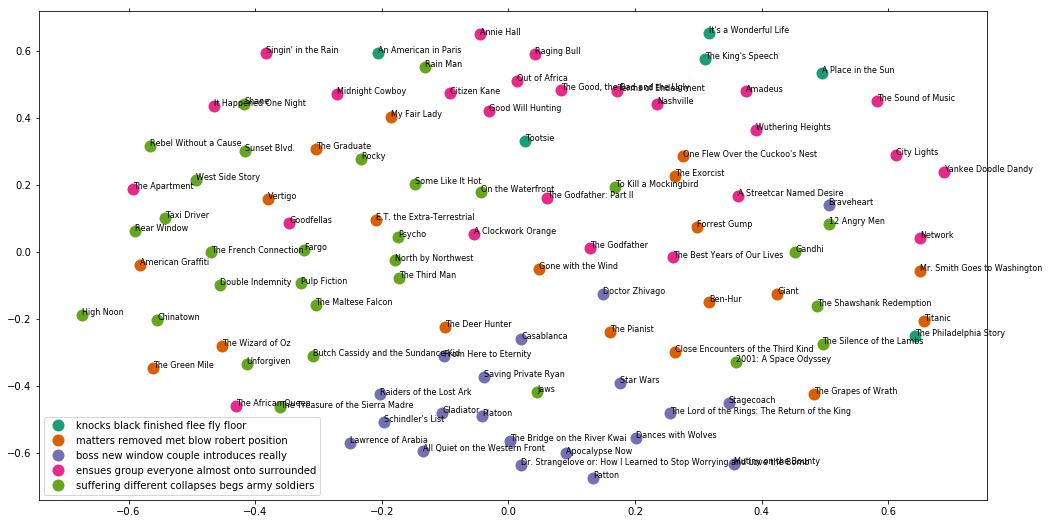

In [44]:
import matplotlib.pyplot as plt

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

## Example 2 -  Clustering Wikipedia

In [45]:
import pandas as pd
import wikipedia

articles=["Ingmar  Bergman"
,"Sarah  Bernhardt"
,"Charlie  Chaplin"
,"Marlene  Dietrich"
,"Walt  Disney"
,"Sergei  Eisenstein"
,"Federico  Fellini"
,"Alfred  Hitchcock"
,"Stanley  Kubrick"
,"Akira  Kurosawa"
,"Marie  Curie"
,"Charles  Darwin"
,"Thomas  Edison"
,"Albert  Einstein"
,"Leonhard  Euler"
,"Michael  Faraday"
,"Enrico  Fermi"
,"Carl Friedrich  Gauss"
,"David  Hilbert"
,"James Clerk  Maxwell"
,"Sir Isaac  Newton"
,"Max  Planck"
,"Ernest  Rutherford"
,"Erwin  Schrödinger"
,"Nikola  Tesla"
,"Alan  Turing"]
wiki_lst=[]
title=[]
for article in articles:
   print("loading content: ",article)
   wiki_lst.append(wikipedia.page(article).content)
   title.append(article)
print("examine content")

loading content:  Ingmar  Bergman
loading content:  Sarah  Bernhardt
loading content:  Charlie  Chaplin
loading content:  Marlene  Dietrich
loading content:  Walt  Disney
loading content:  Sergei  Eisenstein
loading content:  Federico  Fellini
loading content:  Alfred  Hitchcock
loading content:  Stanley  Kubrick
loading content:  Akira  Kurosawa
loading content:  Marie  Curie
loading content:  Charles  Darwin
loading content:  Thomas  Edison
loading content:  Albert  Einstein
loading content:  Leonhard  Euler
loading content:  Michael  Faraday
loading content:  Enrico  Fermi
loading content:  Carl Friedrich  Gauss
loading content:  David  Hilbert
loading content:  James Clerk  Maxwell
loading content:  Sir Isaac  Newton
loading content:  Max  Planck
loading content:  Ernest  Rutherford
loading content:  Erwin  Schrödinger
loading content:  Nikola  Tesla
loading content:  Alan  Turing
examine content


In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words={'english'})
X = vectorizer.fit_transform(wiki_lst)

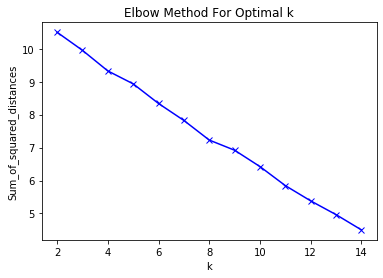

In [49]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(2,15)
for k in K:
   km = KMeans(n_clusters=k, max_iter=1000, n_init=10)
   km = km.fit(X)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [50]:
true_k = 3
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100000, n_init=200, random_state=1)
model.fit(X)
labels=model.labels_
wiki_cl=pd.DataFrame(list(zip(title,labels)),columns=['title','cluster'])
print(wiki_cl.sort_values(by=['cluster']))


                    title  cluster
18         David  Hilbert        0
14        Leonhard  Euler        0
13       Albert  Einstein        0
24          Nikola  Tesla        0
11        Charles  Darwin        0
17  Carl Friedrich  Gauss        0
15       Michael  Faraday        0
16          Enrico  Fermi        0
20      Sir Isaac  Newton        0
21            Max  Planck        0
22     Ernest  Rutherford        0
23     Erwin  Schrödinger        0
19   James Clerk  Maxwell        0
10           Marie  Curie        1
3       Marlene  Dietrich        1
1        Sarah  Bernhardt        1
0         Ingmar  Bergman        2
12         Thomas  Edison        2
8        Stanley  Kubrick        2
7       Alfred  Hitchcock        2
6       Federico  Fellini        2
5      Sergei  Eisenstein        2
4            Walt  Disney        2
2        Charlie  Chaplin        2
9         Akira  Kurosawa        2
25           Alan  Turing        2


Cluster: 0
Titles
      Charles  Darwin
     Albert  Einstein
      Leonhard  Euler
     Michael  Faraday
        Enrico  Fermi
Carl Friedrich  Gauss
       David  Hilbert
 James Clerk  Maxwell
    Sir Isaac  Newton
          Max  Planck
   Ernest  Rutherford
   Erwin  Schrödinger
        Nikola  Tesla


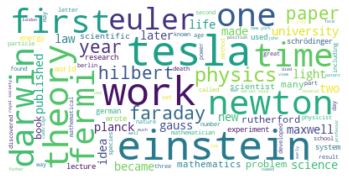

Cluster: 1
Titles
 Sarah  Bernhardt
Marlene  Dietrich
     Marie  Curie


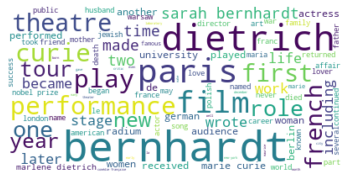

Cluster: 2
Titles
   Ingmar  Bergman
  Charlie  Chaplin
      Walt  Disney
Sergei  Eisenstein
 Federico  Fellini
 Alfred  Hitchcock
  Stanley  Kubrick
   Akira  Kurosawa
    Thomas  Edison
      Alan  Turing


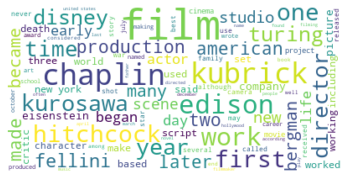

In [51]:
from wordcloud import WordCloud
result={'cluster':labels,'wiki':wiki_lst}
result=pd.DataFrame(result)
for k in range(0,true_k):
   s=result[result.cluster==k]
   text=s['wiki'].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
   print('Cluster: {}'.format(k))
   print('Titles')
   titles=wiki_cl[wiki_cl.cluster==k]['title']         
   print(titles.to_string(index=False))
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()

## References and Credits

***Rose B.***, "*Top 100 Films of all Time*", see [here](http://brandonrose.org/top100) for the original post and [here](https://github.com/brandomr/document_cluster) for the full functional notebook*